# LIBIS TF-IDF Cosine Similarity model training
This notebook trains TF-IDF Cosine Similarity model and serializes model to a file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


from datetime import datetime
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud


In [2]:
# declare constants
# DATASET = '100k'
# DATASET = '1m'
# DATASET = '5m'
# DATASET = '10m'
DATASET = '20m'

MAX_ORDER_AGE_IN_MONTHS = 12
NUM_NEGATIVES = 4
NUM_CLUSTERS = 10

EXPORT_MODEL = True

In [3]:
# u_cols = ['id', 'age_group', 'education', 'gender', 'is_currently_studying']
users = pd.read_csv(r'data/libis/' + DATASET + '/u.user', sep=',')
users = users[['id', 'age_group', 'education', 'gender']]
# users = users[['id', 'age_group', 'education', 'gender', 'is_currently_studying']]

# r_cols = ['user_id', 'record_id', 'timestamp']
orders = pd.read_csv(r'data/libis/' + DATASET + '/u.order-' + str(NUM_NEGATIVES) + '-negatives', sep=',',
                     parse_dates=['timestamp'])
orders = orders[['user_id', 'record_id', 'timestamp', 'order_count']]
print("order count BEFORE dropping outdated orders: {}".format(len(orders)))
orders = orders[orders['timestamp'] > (datetime.now() - relativedelta(months=MAX_ORDER_AGE_IN_MONTHS))]
print("order count AFTER dropping outdated orders: {}".format(len(orders)))
# m_cols = ['id', 'code', 'leader', 'release_date', 'title', 'genres']
records = pd.read_csv(r'data/libis/' + DATASET + '/u.record', sep=',')
records = records[['id', 'code', 'title', 'genres']]
records = records[records.genres.notnull()]

print(users.columns)

order count BEFORE dropping outdated orders: 92315343
order count AFTER dropping outdated orders: 74819655
Index(['id', 'age_group', 'education', 'gender'], dtype='object')


We have a orders file which looks like:

In [4]:
orders.shape

(74819655, 4)

In [5]:
orders.sample(5)

user_id  record_id           timestamp  order_count
12941231    37909      33384 2022-05-12 16:41:11            0
541176       2771      48949 2022-05-12 16:44:47            0
75819864   210128      41674 2022-05-12 16:36:20            0
51866272   144641      39304 2022-05-12 16:45:58            0
19023616    54620      27436 2022-05-12 16:36:44            0

A movies dataset:

In [6]:
records.sample(5)

id                   code  \
44099  44131          C1B0001125604   
24747  24762        C1C1B0000518728   
9742    9753          C1B0003083653   
31567  31586     LIBIS-000000030701   
34536  34557  C421C189C1B0000465239   

                                                   title  \
44099  Šiuolaikinė logistika : vadovėlis / Ramūnas Pa...   
24747  Ne šiaip sau ragana : [apysaka] / Eva Ibbotson...   
9742   Šokoladas : 50 lengvai pagaminamų šokoladinių ...   
31567  Gyvūnų pasaulis : [žaislinė lavinamoji] garsų ...   
34536  451º Farenheito : [romanas] / Ray Bradbury. – ...   

                                                  genres  
44099  Įmonių valdymas. Gamybos, prekybos ir transpor...  
24747             Grožinė literatūra vaikams ir jaunimui  
9742        Namų ūkis. Komunalinis ūkis. Buities tarnyba  
31567                       Pažintinė literatūra vaikams  
34536                                 Grožinė literatūra

Having both a `record_id` , `title` and a string with all genres separated by the character `|` 

And the users dataset, with basic information about the user:

In [7]:
users.head()

id age_group education  gender
0   1     80-89         b  FEMALE
1   2     60-69         d    MALE
2   3       6-8         e    MALE
3   4     18-29         b  FEMALE
4   5       3-5         f    MALE

### Data Exploration

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

We can take a weighted score taking into account both the **orders** and the amount of **views** to answer this question:

In [8]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('record_id', sort=False).record_id.count()
    orders = df.groupby('record_id', sort=False).order_count.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(orders/orders.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('record_id', sort=False).agg({'code':'first',
                                                         'genres':'first', 
                                                         'order_count':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [9]:
df = pd.merge(records, orders, left_on='id', right_on='record_id')
df = pd.merge(df, users, left_on='user_id', right_on='id')
# df = records.merge(orders).merge(users)
weighted_average_score(df).head(10)

code              genres  order_count  views
record_id                                                            
39351      LIBIS-000000200661  Grožinė literatūra     0.778028   5325
44715      LIBIS-000000268708  Grožinė literatūra     0.772692   5090
16642      LIBIS-000000279626  Grožinė literatūra     0.756848   4746
59001      LIBIS-000000270723  Grožinė literatūra     0.737666   4662
27775      LIBIS-000000270722  Grožinė literatūra     0.717386   3917
50189      LIBIS-000000204783  Grožinė literatūra     0.704263   3706
36638      LIBIS-000000138285  Grožinė literatūra     0.692554   3747
9761       LIBIS-000000162041  Grožinė literatūra     0.686754   3684
59673      LIBIS-000000262541  Grožinė literatūra     0.683142   3743
37214      LIBIS-000000211242  Grožinė literatūra     0.678836   3643

#### Genres

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

* *Which are the most popular genres?*

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

The most relevant genres are:

In [10]:
genre_popularity = (records.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Grožinė literatūra                                         22816
Grožinė literatūra vaikams ir jaunimui                     13063
Filosofija, psichologija                                    4238
Medicina                                                    2969
Istorija                                                    2385
Bendrasis skyrius                                           2005
Etnografija. Papročiai. Tautosaka                           1811
Religija, teologija                                         1713
Politika                                                    1616
Švietimas. Ugdymas. Mokymas. Laisvalaikio organizavimas     1527
Name: genres, dtype: int64

Or for a more visual representation we could plot a word-cloud with the genres:

(-0.5, 999.5, 399.5, -0.5)

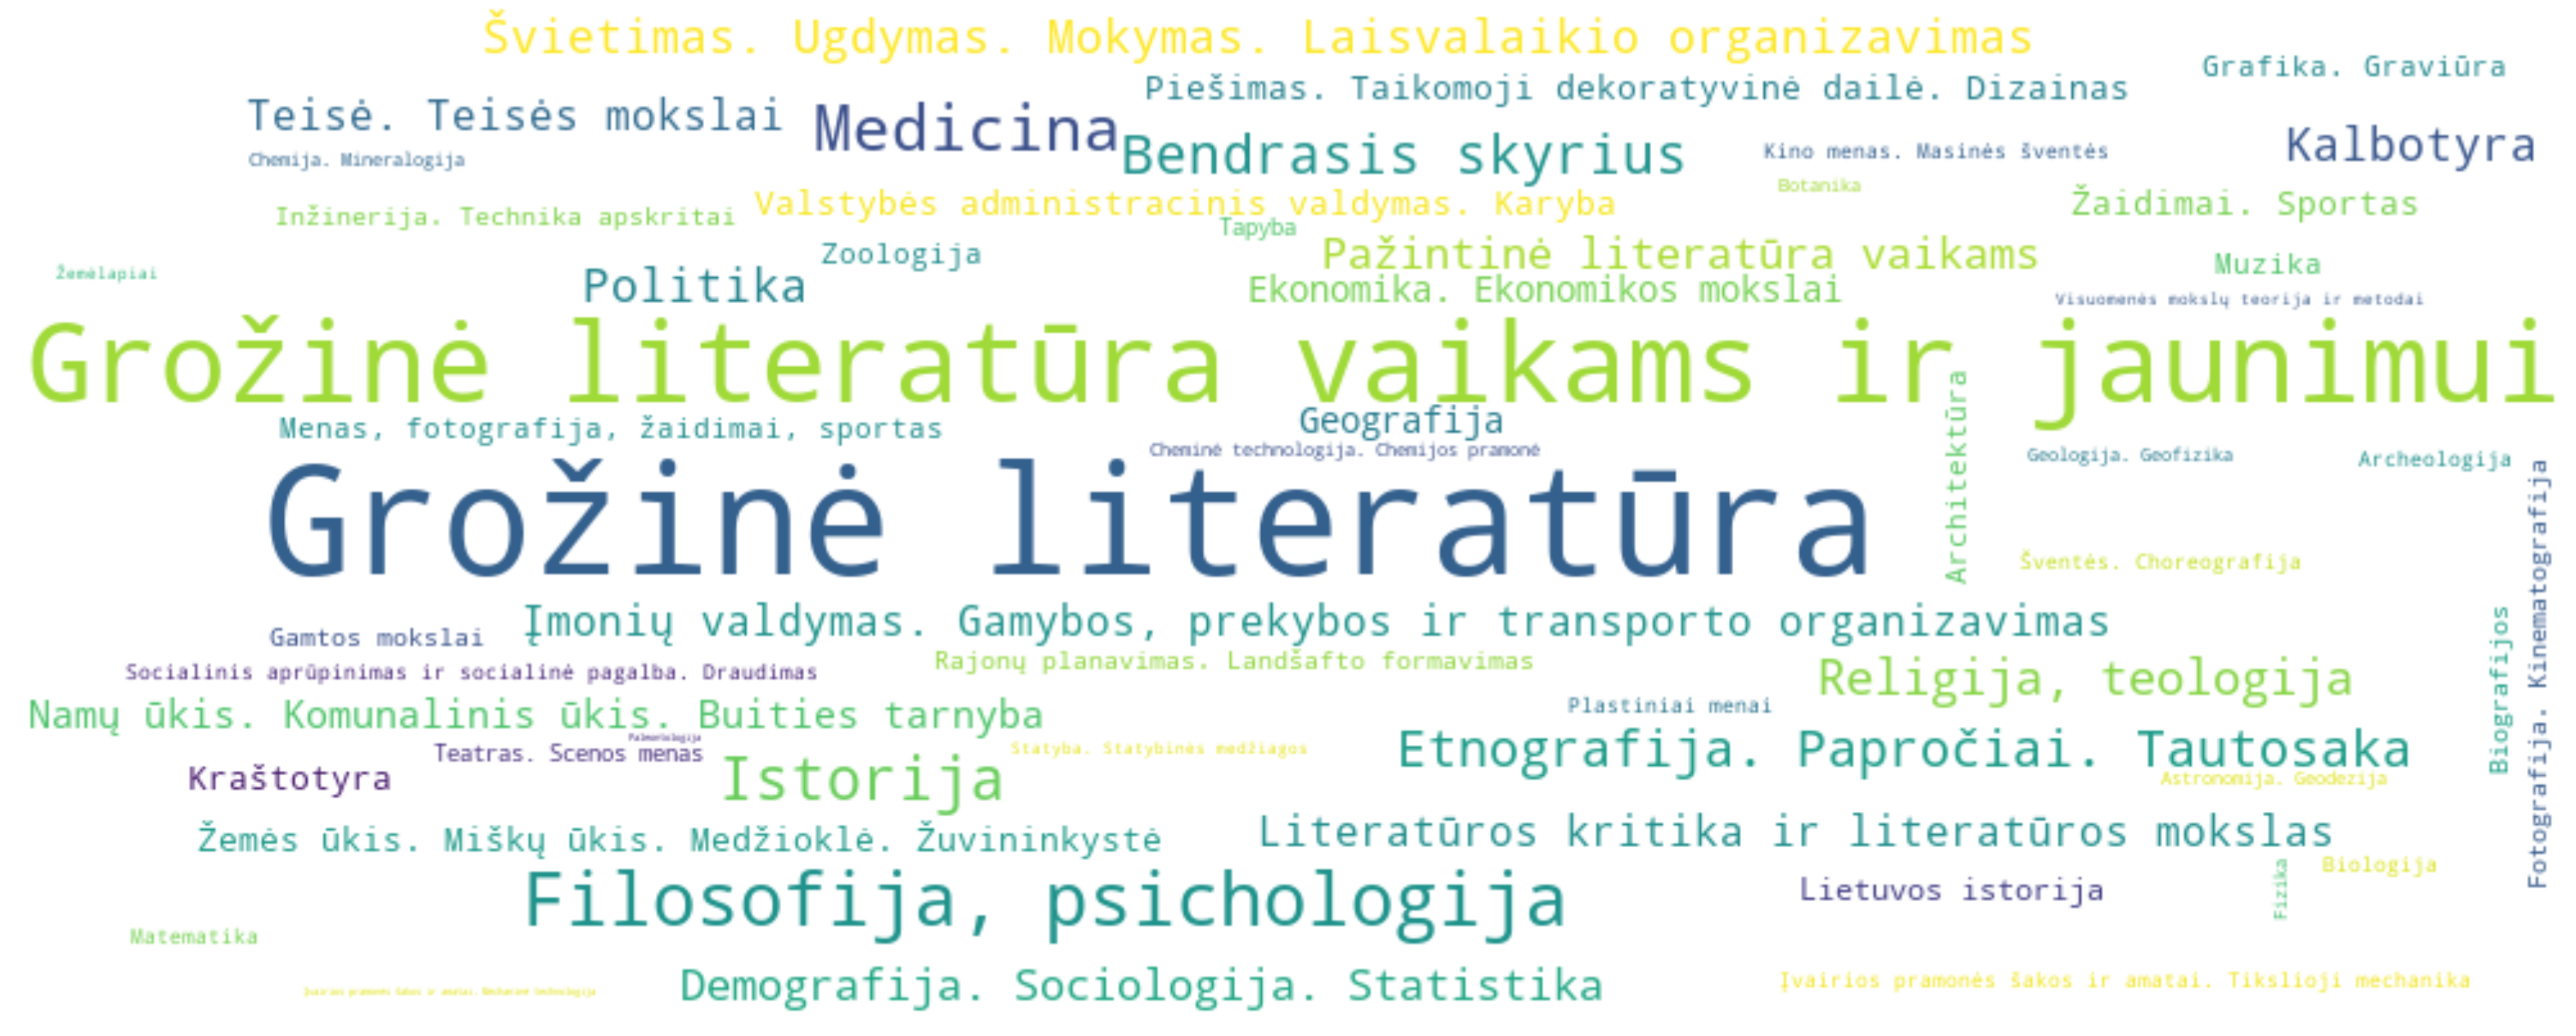

In [11]:
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(64, 32))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

As we can see, the most frequent genres are `'Grožinė literatūra'`, `'Grožinė literatūra vaikams ir jaunimui'` and `'Filosofija, psichologija'`, among others. We then have some other genres that are way less frequent such as `'Medicina'`, `'Politika'` or `'Geografija'`. 

As I previously pointed out, these are the genres that we want to give the most importance to when recommending. Why is that?
As an example let's consider new user wants to find records similar to Interstellar., which is a mixture of `'Istorija|Valstybės administracinis valdymas. Karyba|Grožinė literatūra'`. Say now that among the available records to recommend we have a collection of `'Grožinė literatūra'` records and some other `'Istorija'` records too. Which should we prioritise? In this case, it seems reasonable to assume that the less generic genre, `'Istorija'`, will be the most relevant in terms of characterising the record.

## Building a content based recommender

For the post, we will be building a fairly simple recommender, based on the movie genres. A fairly common approach is to use a tf-idf vectorizer. 

While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data. The expression is defined as follows:

![netflix](images/tfidf.jpg)

Where we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side factor, which basically scales the term frequency depending on the amount of times a given term appears in all documents (records).

The lesser the amount of records that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically to smoothen the result of the division, i.e. avoids huge differences as a result of the right hand term.

So why is this useful in our case?

As already mentioned, tf-idf will help capture the important genres of each record by giving a higher weight to the less frequent genres, which we woulnd't get with say, CountVectorizer .

### tf-idf

To obtain the tf-idf vectors I'll be using sklearn's TfidfVectorizer . However, we have to take into account some aspects particular to this problem. The usual setup when dealing with text data, is to set a word analyser and perhaps an ngram_range , which will also include the n-grams within the specified range. An example would be:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
records.head(3)

id         code                                              title  \
0   1  LNB023B9438  Harė Krišna vegetariniai valgiai / Adiradža da...   
1   2  LNB026BD3C8  Mykolas Žilinskas : Jis apie save, mes apie jį...   
2   3  LNB026BEB38  Mokymo kursas personalui, dirbančiam su sutrik...   

                                              genres  
0       Namų ūkis. Komunalinis ūkis. Buities tarnyba  
1              Menas, fotografija, žaidimai, sportas  
2  Filosofija, psichologija|Medicina|Socialinis a...

Example of tf-idf vectorization with string

In [14]:
s = "Animation Children's Comedy"
tf_wrong = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tf_wrong.fit([s])
tf_wrong.get_feature_names()
# ['animation', 'animation children', 'children', 'children comedy', 'comedy']

c:\users\kazim\sources\uni\libis-rs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['animation', 'animation children', 'children', 'children comedy', 'comedy']

However, that doesn't really make sense in this case, since the order of the genres is not relevant, we want to account for the combinations of genres for a given movie, regardless of the order. So for the example above, we'd want:

In [15]:
[c for i in range(1,2) for c in combinations(s.split(), r=i)]

[('Animation',), ("Children's",), ('Comedy',)]

Here we're finding the sets of combinations of genres up to k (4 here), or in mathematical terms, the superset.
We can apply the above logic using the analyser parameter, which we can use to obtain the sequence of features from the raw input using a callable:

In [16]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(records['genres'])
tfidf_matrix.shape

(59795, 2471)

Which will result in the following tf-idf vectors (note that only a subset of the columns and rows is sampled):

In [17]:
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names(), index=records.code).sample(5, axis=1).sample(10, axis=0)


(Bendrasis skyrius, Rajonų planavimas. Landšafto formavimas, Teisė. Teisės mokslai)  \
code                                                                                                     
C1BLNB06FF36E5                                                   0.0                                     
C19C2110000001451                                                0.0                                     
C1B0003189193                                                    0.0                                     
C130001412347                                                    0.0                                     
LNB04CD5ED4                                                      0.0                                     
C1B0003233409                                                    0.0                                     
C1B0000046847                                                    0.0                                     
C1B0003843264                                                    0.0                                     
C1B0000667651                                                    0.0                                     
C1BLNB03A9CE20                                                   0.0                                     

                   (Demografija. Sociologija. Statistika, Filosofija, psichologija, Politika)  \
code                                                                                            
C1BLNB06FF36E5                                                   0.0                            
C19C2110000001451                                                0.0                            
C1B0003189193                                                    0.0                            
C130001412347                                                    0.0                            
LNB04CD5ED4                                                      0.0                            
C1B0003233409                                                    0.0                            
C1B0000046847                                                    0.0                            
C1B0003843264                                                    0.0                            
C1B0000667651                                                    0.0                            
C1BLNB03A9CE20                                                   0.0                            

                   (Chemija. Mineralogija, Fizika, Grožinė literatūra vaikams ir jaunimui)  \
code                                                                                         
C1BLNB06FF36E5                                                   0.0                         
C19C2110000001451                                                0.0                         
C1B0003189193                                                    0.0                         
C130001412347                                                    0.0                         
LNB04CD5ED4                                                      0.0                         
C1B0003233409                                                    0.0                         
C1B0000046847                                                    0.0                         
C1B0003843264                                                    0.0                         
C1B0000667651                                                    0.0                         
C1BLNB03A9CE20                                                   0.0                         

                   (Medicina, Namų ūkis. Komunalinis ūkis. Buities tarnyba, Švietimas. Ugdymas. Mokymas. Laisvalaikio organizavimas)  \
code                                                                                                                                   
C1BLNB06FF36E5                                                   0.0                                                                   
C19C2110000001451                           

------

<h2> Similarity between vectors </h2>

The next step will be to find similar vectors (records). Recall that we've encoded each record's genre into its tf-idf representation, now we want to define a proximity measure. A commonly used measure is the cosine similarity. 

This similarity measure owns its name to the fact that it equals to the cosine of the angle between the two vectors being compared. The lower the angle between two vectors, the higher the cosine will be, hence yielding a higher similarity factor. It is expressed as follows ([source](https://en.wikipedia.org/wiki/Cosine_similarity)):

Where, since the inner product can be expressed as the product of the magnitudes times the cosing of the angle between the two vectors, it becomes clear that the above can be expressed as the cosine [source](https://en.wikipedia.org/wiki/Cosine_similarity):

So here we'll be obtaining the cosine by taking the inner product between both vectors, and normalising by their respective magnitudes. 

To compute the cosine similarities between all tf-idf vectors, we can again use scikit-learn. `sklearn.metrics.pairwise` contains many pairwise distance metrics, among them `cosine_similarity`, which will compute the cosine similarities between all the input rows, in this case tf-idf vectors:

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [19]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=records['code'], columns=records['code'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (59795, 59795)


code                LNB0244A488  C1C1B0000580663  C3060000044669  \
code                                                               
LNB023B9438                0.00              0.0             0.0   
LNB026BD3C8                0.00              0.0             0.0   
LNB026BEB38                0.00              0.0             0.0   
LNB02DEA268                0.00              0.0             1.0   
LNB02E4E3F8                0.00              0.0             1.0   
...                         ...              ...             ...   
LIBIS-000000074401         0.00              0.0             0.0   
LIBIS-000000148281         0.00              0.0             0.0   
LIBIS-000000209461         0.00              0.0             0.0   
LIBIS-000000237761         0.22              0.0             0.0   
C1BLNB00000122             1.00              0.0             0.0   

code                C1B0000200401  LIBIS-000000116924  
code                                                   
LNB023B9438                  0.00                 0.0  
LNB026BD3C8                  0.00                 0.0  
LNB026BEB38                  0.00                 0.0  
LNB02DEA268                  0.00                 1.0  
LNB02E4E3F8                  0.00                 1.0  
...                           ...                 ...  
LIBIS-000000074401           0.00                 0.0  
LIBIS-000000148281           0.00                 0.0  
LIBIS-000000209461           0.00                 0.0  
LIBIS-000000237761           0.22                 0.0  
C1BLNB00000122               1.00                 0.0  

[59795 rows x 5 columns]

In [20]:
# export model (dataframe)
if EXPORT_MODEL:
    now = datetime.now()
    now_string = now.strftime("%Y%m%d-%H%M")
    model_filename = "models/model-tfidf-" + DATASET + "-" + now_string + ".pkl"

    display(cosine_sim_df.sample(10))
    cosine_sim_df.to_pickle(model_filename)
    print('model exported to: ' + model_filename)

    cosine_sim_df = pd.read_pickle(model_filename)
    display(cosine_sim_df.sample(10))

code                LNB023B9438  LNB026BD3C8  LNB026BEB38  LNB02DEA268  \
code                                                                     
C1B0000700275               0.0          0.0          0.0          1.0   
LNB02C90B10                 0.0          0.0          0.0          0.0   
C1BLNB03416BB7              0.0          0.0          0.0          0.0   
C1B0000421628               0.0          0.0          0.0          0.0   
C19C1B0001717432            0.0          0.0          0.0          1.0   
LIBIS-000000184961          0.0          0.0          0.0          0.0   
C1B0001088027               0.0          0.0          0.0          1.0   
C420C4140000018939          0.0          0.0          0.0          1.0   
C1B0000381012               0.0          0.0          0.0          0.0   
LNB024C68D0                 0.0          0.0          0.0          0.0   

code                LNB02E4E3F8  C4200000125969  LNB037BEFF0  LNB021612A8  \
code                                                                        
C1B0000700275               1.0             1.0     0.262844          0.0   
LNB02C90B10                 0.0             0.0     0.000000          0.0   
C1BLNB03416BB7              0.0             0.0     0.000000          0.0   
C1B0000421628               0.0             0.0     0.000000          0.0   
C19C1B0001717432            1.0             1.0     0.262844          0.0   
LIBIS-000000184961          0.0             0.0     0.000000          0.0   
C1B0001088027               1.0             1.0     0.262844          0.0   
C420C4140000018939          1.0             1.0     0.262844          0.0   
C1B0000381012               0.0             0.0     0.000000          0.0   
LNB024C68D0                 0.0             0.0     0.000000          0.0   

code                LNB02436050  LNB02475FC0  ...  C1B0002913069  \
code                                          ...                  
C1B0000700275               0.0          0.0  ...       0.000000   
LNB02C90B10                 0.0          0.0  ...       1.000000   
C1BLNB03416BB7              0.0          0.0  ...       1.000000   
C1B0000421628               0.0          0.0  ...       1.000000   
C19C1B0001717432            0.0          0.0  ...       0.000000   
LIBIS-000000184961          0.0          0.0  ...       0.306139   
C1B0001088027               0.0          0.0  ...       0.000000   
C420C4140000018939          0.0          0.0  ...       0.000000   
C1B0000381012               0.0          0.0  ...       1.000000   
LNB024C68D0                 0.0          0.0  ...       0.000000   

code                C1B0003057270  C1B0000206471  LIBIS-000000037393  \
code                                                                   
C1B0000700275                 0.0            0.0                 1.0   
LNB02C90B10                   0.0            0.0                 0.0   
C1BLNB03416BB7                0.0            0.0                 0.0   
C1B0000421628                 0.0            0.0                 0.0   
C19C1B0001717432              0.0            0.0                 1.0   
LIBIS-000000184961            0.0            0.0                 0.0   
C1B0001088027                 0.0            0.0                 1.0   
C420C4140000018939            0.0            0.0                 1.0   
C1B0000381012                 0.0            0.0                 0.0   
LNB024C68D0                   0.0            0.0                 0.0   

code                LIBIS-000000041861  LIBIS-000000074401  \
code                                                         
C1B0000700275                      0.0                 0.0   
LNB02C90B10                        0.0                 0.0   
C1BLNB03416BB7                     0.0                 0.0   
C1B0000421628                      0.0                 0.0   
C19C1B0001717432                   0.0                 0.0   
LIBIS-000000184961                 0.0                 0.0   
C1B00010

model exported to: models/model-tfidf-20m-20220515-1510.pkl


code                LNB023B9438  LNB026BD3C8  LNB026BEB38  LNB02DEA268  \
code                                                                     
C1B0001750547               0.0          0.0     0.000000     0.000000   
LIBIS-000000053185          0.0          0.0     0.026963     0.000000   
C13LNB02EAE320              0.0          0.0     0.000000     1.000000   
C1B0000035772               0.0          0.0     0.000000     0.000000   
C1B0000983833               0.0          0.0     0.000000     0.000000   
C1670000074917              0.0          0.0     0.000000     0.000000   
C1B0002279097               0.0          0.0     0.000000     0.230712   
C1B0001211793               0.0          0.0     0.000000     0.000000   
C209C2150000091044          0.0          0.0     0.132438     0.000000   
C2130000052153              0.0          0.0     0.000000     0.000000   

code                LNB02E4E3F8  C4200000125969  LNB037BEFF0  LNB021612A8  \
code                                                                        
C1B0001750547          0.000000        0.000000     0.000000          0.0   
LIBIS-000000053185     0.000000        0.000000     0.000000          0.0   
C13LNB02EAE320         1.000000        1.000000     0.262844          0.0   
C1B0000035772          0.000000        0.000000     0.000000          0.0   
C1B0000983833          0.000000        0.000000     0.000000          0.0   
C1670000074917         0.000000        0.000000     0.000000          0.0   
C1B0002279097          0.230712        0.230712     0.060641          0.0   
C1B0001211793          0.000000        0.000000     0.000000          0.0   
C209C2150000091044     0.000000        0.000000     0.000000          0.0   
C2130000052153         0.000000        0.000000     0.000000          0.0   

code                LNB02436050  LNB02475FC0  ...  C1B0002913069  \
code                                          ...                  
C1B0001750547               0.0          0.0  ...            0.0   
LIBIS-000000053185          0.0          0.0  ...            0.0   
C13LNB02EAE320              0.0          0.0  ...            0.0   
C1B0000035772               0.0          0.0  ...            0.0   
C1B0000983833               0.0          0.0  ...            0.0   
C1670000074917              0.0          0.0  ...            0.0   
C1B0002279097               0.0          0.0  ...            0.0   
C1B0001211793               0.0          0.0  ...            0.0   
C209C2150000091044          0.0          0.0  ...            0.0   
C2130000052153              0.0          0.0  ...            1.0   

code                C1B0003057270  C1B0000206471  LIBIS-000000037393  \
code                                                                   
C1B0001750547            0.420931       0.000000            0.000000   
LIBIS-000000053185       0.113358       0.509643            0.000000   
C13LNB02EAE320           0.000000       0.000000            1.000000   
C1B0000035772            0.000000       0.000000            0.000000   
C1B0000983833            0.000000       0.000000            0.000000   
C1670000074917           0.000000       0.000000            0.000000   
C1B0002279097            0.000000       0.000000            0.230712   
C1B0001211793            0.000000       0.000000            0.000000   
C209C2150000091044       0.000000       0.000000            0.000000   
C2130000052153           0.000000       0.000000            0.000000   

code                LIBIS-000000041861  LIBIS-000000074401  \
code                                                         
C1B0001750547                      0.0            0.000000   
LIBIS-000000053185                 0.0            0.223456   
C13LNB02EAE320                     0.0            0.000000   
C1B0000035772                      0.0            0.000000   
C1B0000983833                      0.0            0.000000   
C1670000074917                     0.0            0.000000   
C1B00022

Now we have to define some logic to find the highest weights or tf-idf scores for a given movie. For that I've defined the following function, which takes as input a given movie i, the similarity matrix M, the items dataframe and returns up to k recommendations:

In [21]:
def genre_recommendations(i, M, items, k=10):
    """
    Recommends records based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with records as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Where by using argpartition we take the k highest values in M(similarity matrix) on a given index (movie) i . We then index on the columns in M , and further slice to get from highest weights to lowest.

----

#### Testing the recommender

Let's test the recommender with a few examples.

Check if works correctly with children literature, for example what recommendation we would get for `'Kakė Makė ir pavogtas laikas'`?

In [22]:
records[records.code.eq('LIBIS-000000000481')]

id                code  \
19033  19048  LIBIS-000000000481   

                                                   title  \
19033  Kakė Makė ir pavogtas laikas : [pasaka] / Lina...   

                                       genres  
19033  Grožinė literatūra vaikams ir jaunimui

We can see that its genres are `'Grožinė literatūra vaikams ir jaunimui'`. Let's see what recommendations we get:

In [23]:
genre_recommendations('LIBIS-000000000481', cosine_sim_df, records)

code     id  \
0      C1BLNB00000122  60000   
1  C214C4110000006102  13518   
2        C10002339214  42939   
3   C19C1700000017872  13513   
4       C130000470833  13511   
5      C19LNB0283C898  42946   
6         B8800000010  13524   
7  LIBIS-000000090401  13494   
8        C10000289446  13507   
9     C306B210000126A  42950   

                                               title  \
0  Žydras povas povinėja : eil. rinktinė vaikams ...   
1  Pingvino nuotykiai : Pašėlę Tomo ir Džerio nuo...   
2  Wnuczka do orzechów / Małgorzata Musierowicz. ...   
3  Аленький цветочек / Сергей Тимофеевич Аксаков....   
4  Harry Potter and the goblet of fire / J.K. Row...   
5  Mikis ir trys pupos / Walt Disney. – Vilnius :...   
6  Burtų pasaulis : pasakos / Šarlis Pero. – [1-a...   
7  Pašėlęs Liucės pasaulis : [apysaka] / Anna Lot...   
8  Сказки / Вильям Гауф. Сказки и истории / Ханс ...   
9  Сказки / Ганс Христиан Андерсен. – Санкт-Петер...   

                                   genres  
0  Grožinė literatūra vaikams ir jaunimui  
1  Grožinė literatūra vaikams ir jaunimui  
2  Grožinė literatūra vaikams ir jaunimui  
3  Grožinė literatūra vaikams ir jaunimui  
4  Grožinė literatūra vaikams ir jaunimui  
5  Grožinė literatūra vaikams ir jaunimui  
6  Grožinė literatūra vaikams ir jaunimui  
7  Grožinė literatūra vaikams ir jaunimui  
8  Grožinė literatūra vaikams ir jaunimui  
9  Grožinė literatūra vaikams ir jaunimui

As expected, the most similar records are those which share the most genres. Interestingly, we see that most of them are Sci-Fi records. Note that this is likely to be influenced by the fact that Sci-Fi will mostly have the higher score among the genres that appear above, since it is the least frequent and hence has a higher weight.

Let's try with `Medical` record:

In [24]:
print(records[records.code.eq('C1B0003952954')])

          id           code  \
15247  15262  C1B0003952954   

                                                   title    genres  
15247  Daktarės Filomenos Taunytės priimamasis / [sud...  Medicina  


We get:

In [25]:
genre_recommendations('C1B0003952954', cosine_sim_df, records)

code     id  \
0           C1B0003071029  11192   
1           C1B0002065690  27356   
2           C1B0001609470  42248   
3           C1B0003528769  27362   
4          C1BLNB068E3903  45565   
5          C1BLNB01C9BF98  48704   
6      LIBIS-000000065102  52514   
7   C19LIBIS-000000031281  55589   
8             A2100000CB6  22755   
9  C15C416C1C1B0000837895  10712   

                                               title    genres  
0  Sveikata, kuri mus saugo / Juozas Dapšauskas. ...  Medicina  
1  Žalumynai gyvenimui / Victoria Boutenko. – Kau...  Medicina  
2  Šiuolaikinė psichoterapija / [sudarytojai] Ray...  Medicina  
3  Diukano dieta : [gyvenimo būdo vadovas norinti...  Medicina  
4  Veterinarijos gydytojo vadovas / [sudarytojas ...  Medicina  
5  Gydymas vandeniu ir augalais / Sebastianas Kne...  Medicina  
6  Sąnarių paslankumą ir raumenų jėgą lavinamosio...  Medicina  
7  Geriausi gamtos vaistai : ligas gydantys ir sv...  Medicina  
8  Klinikinė chirurgija : vadovėlis LTSR aukšt. m...  Medicina  
9  Judesių mokslas: raumenys, valdymas, mokymas, ...  Medicina

Let's try with a record which has multiple genres like `'Dievų miškas'`, whose genres are `'Istorija|Valstybės administracinis valdymas. Karyba|Grožinė literatūra'`:

In [26]:
records[records.code.eq('LNB0551D101')]

id         code                                              title  \
21999  22014  LNB0551D101  Dievų miškas / B. Sruoga. – Kaunas : Šviesa, 1...   

                                                  genres  
21999  Grožinė literatūra|Istorija|Valstybės administ...

In [27]:
genre_recommendations('LNB0551D101', cosine_sim_df, records)

code     id  \
0   C15C1630000093526  59377   
1        C10000095409  31034   
2         LNB1ED24468   9776   
3      C1BLNB019F19A0  51989   
4         LNB033E5E3E  13834   
5       C1B0000660268  19658   
6       C1B0001417886   8160   
7  C421C3030000073542  22688   
8  LIBIS-000000154501  48312   
9         LNB03D51857  49104   

                                               title  \
0  Neužmiršk erškėčių meto : Vermachto kulkosvaid...   
1  Fronto užrašai : iš kontržvalgybos karininko u...   
2  Laisvės troškimo kaina : istorinė apybraiža / ...   
3  Daugel krito sūnų … : [atsiminimai] / Adolfas ...   
4  Dievų miškas : atsiminimai / Balys Sruoga. – V...   
5  Daugel krito sūnų… : partizanų gretose / Adolf...   
6  Kraujo krešulys : Afganistanas, 2006 : britų p...   
7  Šalia mirties / Juozas Jakavonis. – 2-oji pata...   
8  Afganistano mėsmalė, 1979–1989 m. / Mindaugas ...   
9  Dievų miškas / Balys Sruoga. – Vilnius : Vaga,...   

                                              genres  
0  Grožinė literatūra|Istorija|Valstybės administ...  
1  Grožinė literatūra|Istorija|Valstybės administ...  
2  Grožinė literatūra|Istorija|Valstybės administ...  
3  Grožinė literatūra|Istorija|Valstybės administ...  
4  Grožinė literatūra|Istorija|Valstybės administ...  
5  Grožinė literatūra|Istorija|Valstybės administ...  
6  Grožinė literatūra|Istorija|Valstybės administ...  
7  Grožinė literatūra|Istorija|Valstybės administ...  
8  Grožinė literatūra|Istorija|Valstybės administ...  
9  Grožinė literatūra|Istorija|Valstybės administ...

Or with record of genres `'Žaidimai. Sportas'`:

In [28]:
records[records.code.eq('LIBIS-000000037819')]

id                code  \
41417  41448  LIBIS-000000037819   

                                                   title             genres  
41417  Minecraft. Kaip viską sukurti / [teksto autori...  Žaidimai. Sportas

In [29]:
genre_recommendations('LIBIS-000000037819', cosine_sim_df, records)

code     id  \
0       C3000000068963   1795   
1  C420C1C1B0000046449   3568   
2        C1B0000242822  13384   
3      C1BC10000136458  41396   
4        C1B0002160426  27293   
5          LNB001846DB  17478   
6       C1BLNB0358A113  34818   
7      C1C1B0000525700  49890   
8         C10001153364  59322   
9        C1B0000773435  52761   

                                               title             genres  
0  Dvigubas šešetas : Domino kauliukų žaidimas. –...  Žaidimai. Sportas  
1  Kovos menai / David Mitchell. – Vilnius : Alma...  Žaidimai. Sportas  
2  Raumenų lavinimo pratimai ir jų ypatumai : stu...  Žaidimai. Sportas  
3  Dvikova / Gedvydas Vainauskas. – Vilnius : Vyt...  Žaidimai. Sportas  
4  Kortų žaidimai : [įdomybės, žaidimai, būrimai,...  Žaidimai. Sportas  
5  Judrieji žaidimai / V. Kuklys. – Kaunas : Švie...  Žaidimai. Sportas  
6  Kai prabyla sporto žvaigždės : apybraižos, pok...  Žaidimai. Sportas  
7  Auksinis krepšininkų triumfas : [Švedija - 200...  Žaidimai. Sportas  
8  Athletics in ancient Greece : albumas / Nicola...  Žaidimai. Sportas  
9  Golfas / Gavin  Newsham. – Vilnius : Alma litt...  Žaidimai. Sportas

------

### Concluding

Overall, we've seen that quite a naive content based recommendation as the reviewed can provide fairly good recommendations.

A clear advantage of content based recommendations is that they don't suffer from the cold-start problem, since we only need basic information on a user (in this case a single ordered record) to provide similar recommendations based on the items.
Another interesting advantage is that we are able to recommend to users with unique tastes, as well as new an unpopular items.

An important drawback however  is that it tends to recommend the same type of items to the user. In order to be able to recommend a different type of item, the user would have to have rated or show interest in the new type of item. This is a problem that Collaborative Filtering methods don't have, since the match here is done between neighbouring users with similar tastes, but different items rated.